# LeNet-5-Quantized

In this notebook, i want to demonstrate how i built LeNet-5 in PyTorch and Quantize it for visualization.


> Network details in this [Blog post ](https://engmrk.com/lenet-5-a-classic-cnn-architecture/) and architecture view can be found below.


![alt text](https://miro.medium.com/max/2625/1*1TI1aGBZ4dybR6__DI9dzA.png)


# Requirments


*   PyTorch (torch)
*   torchvision
*   numpy
*   pillow (PIL)



In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from PIL import Image


# MNIST Dataset

We will download the dataset with `torchvision` and add to it some transforms like padding so the size of the input images become 32x32.

We then split the data to `train_data` and `test_data` randomly.

We make another split in the training data for validation purposes using `SubsetRandomSampler`.



In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
#  validation sample
valid_sample = 0.2

transform = [transforms.Pad(2), transforms.ToTensor()]

# choose the training and test datasets
train_data = datasets.MNIST(root='data',
                            train=True,
                            download=True,
                            transform=transforms.Compose(transform))
test_data = datasets.MNIST(root='data',
                           train=False,
                           download=True,
                           transform=transforms.Compose(transform))

# Creating validation sampler
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_sample * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

# define sampler for batches
trainSampler = SubsetRandomSampler(train_idx)
validationSampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=trainSampler,
                          num_workers=num_workers)
validation_loader = DataLoader(train_data,
                               batch_size=batch_size,
                               sampler=validationSampler,
                               num_workers=num_workers)
test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         num_workers=num_workers)


# LeNet-5 Network

We inherited form `nn.Module` to construct the LeNet-5 architecture in two steps


1.   initialization of layers in `__init__`
2.   connecting layers to build the pipeline of the network in `forward`



In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 32 x 32 x 1
        self.conv1 = nn.Conv2d(1, 6, (5, 5), padding=0, stride=1)
        # 28 x 28 x 6
        self.pool1 = nn.AvgPool2d((2, 2), stride=2)
        # 14 x 14 x 6
        self.conv2 = nn.Conv2d(6, 16, (5, 5), padding=0, stride=1)
        # 10 x 10 x 16
        self.pool2 = nn.AvgPool2d((2, 2), stride=2)
        # 5 x 5 x 16
        self.conv3 = nn.Conv2d(16, 120, (5, 5), padding=0, stride=1)
        # 1 x 1 x 120
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        # Choose either view or flatten (as you like)
        x = x.view(x.size(0), -1)
        # x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x
      
model = LeNet()
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


# Configurations

Here, we configure the loss function to be `CrossEntropyLoss` and the optimizer to be Stochastic Gradient Descent (`SGD`).

In [0]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Number of epochs
n_epochs = 30

# classes of MNIST
classes = list(range(10))


# Training & Validation

We first check if a GPU is available so i can transfer the learning to it then,  we put the model in training mode and after every epoch we put the model to `eval` mode so we check the validataion loss is getting better or not to save it in `model.pt`.

In [0]:

# Choosing the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training Device: {}".format(device))

model.to(device)

valid_loss_min = np.Inf

for epoch in range(n_epochs):

    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()  # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.to(device))
        # calculate the loss
        loss = criterion(output, target.to(device))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)

    model.eval()
    for data, target in validation_loader:
        output = model(data.to(device))
        loss = criterion(output, target.to(device))
        valid_loss += loss.item() * data.size(0)

    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(validation_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.
          format(epoch + 1, train_loss, valid_loss))
    if valid_loss <= valid_loss_min:
        print(
            'Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
            .format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss


Training Device: cuda:0
Epoch: 1 	Training Loss: 1.674509 	Validation Loss: 1.675145
Validation loss decreased (inf --> 1.675145).  Saving model ...
Epoch: 2 	Training Loss: 1.673003 	Validation Loss: 1.672946
Validation loss decreased (1.675145 --> 1.672946).  Saving model ...
Epoch: 3 	Training Loss: 1.671563 	Validation Loss: 1.675842
Epoch: 4 	Training Loss: 1.645988 	Validation Loss: 1.606506
Validation loss decreased (1.672946 --> 1.606506).  Saving model ...
Epoch: 5 	Training Loss: 1.600649 	Validation Loss: 1.597492
Validation loss decreased (1.606506 --> 1.597492).  Saving model ...
Epoch: 6 	Training Loss: 1.572462 	Validation Loss: 1.519606
Validation loss decreased (1.597492 --> 1.519606).  Saving model ...
Epoch: 7 	Training Loss: 1.513188 	Validation Loss: 1.512397
Validation loss decreased (1.519606 --> 1.512397).  Saving model ...
Epoch: 8 	Training Loss: 1.506405 	Validation Loss: 1.509676
Validation loss decreased (1.512397 --> 1.509676).  Saving model ...
Epoch: 9 	

# Testing

Going through the testing dataset to get the accuracy of the model.

In [8]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model = LeNet()
model.load_state_dict(torch.load("model.pt"))
model.eval()  # prep model for *evaluation*

# Choosing the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Testing Device: {}".format(device))

model.to(device)

# Disabling the gradient calculations for faster inference
with torch.no_grad():

  for data, target in test_loader:
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data.to(device))
      # calculate the loss
      loss = criterion(output, target.to(device))
      # update test loss
      test_loss += loss.item() * data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %
              (str(i), 100 * class_correct[i] / class_total[i],
               np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' %
              (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' %
      (100. * np.sum(class_correct) / np.sum(class_total),
       np.sum(class_correct), np.sum(class_total)))


Testing Device: cpu
Test Loss: 1.586920

Test Accuracy of     0: 98% (966/980)
Test Accuracy of     1: 98% (1123/1135)
Test Accuracy of     2: 97% (1002/1032)
Test Accuracy of     3: 96% (973/1010)
Test Accuracy of     4: 98% (965/982)
Test Accuracy of     5: 92% (827/892)
Test Accuracy of     6: 97% (935/958)
Test Accuracy of     7: 97% (1004/1028)
Test Accuracy of     8: 96% (938/974)
Test Accuracy of     9:  0% ( 0/1009)

Test Accuracy (Overall): 87% (8733/10000)


# Quantization

We deliver a visual representation to the feature maps generated from the learnt weights.

In [9]:

def quantize_arr(arr):
    ''' Quantization based on linear rescaling over min/max range.'''
    min_val, max_val = np.min(arr), np.max(arr)

    if max_val - min_val > 0:
        quantized = np.round(255 * (arr - min_val) / (max_val - min_val))
    else:
        quantized = np.zeros(arr.shape)

    quantized = quantized.astype(np.uint8)
    min_val = min_val.astype(np.float32)
    max_val = max_val.astype(np.float32)

    return quantized, min_val, max_val

example = np.random.randn(5, 5)
print(example)
quant, min_val, max_val = quantize_arr(example)
print("\n{}, Min_Val: {}, Max_Val: {}".format(quant, min_val, max_val))  
    


[[ 1.19885451 -1.26105021  0.6662166  -1.1327998  -0.50894754]
 [-0.92032074 -0.14465888  0.77838943 -0.3921359   0.10356401]
 [-0.01419159  0.40554421  1.82957351 -1.55957709 -1.14318015]
 [ 1.97772324  1.24335393 -0.12788415  0.23618205  1.66425121]
 [-0.22514084  0.75146523  0.68724146 -1.61813965  0.29537516]]

[[200  25 162  34  79]
 [ 49 104 170  87 122]
 [114 144 244   4  34]
 [255 203 106 131 233]
 [ 99 168 163   0 136]], Min_Val: -1.618139624595642, Max_Val: 1.977723240852356


# Network Analysis
We will go through every layer and print its weights (if any) and the feature maps (outputs).

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 16, 5, 5])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


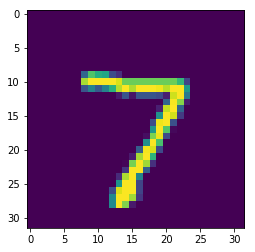

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving the model back to the CPU
model.to("cpu")

# parameters of the trained network
param = list(model.parameters())
for paramater in model.parameters():
  print(paramater.shape)
  
  
# Input image for analysis
input_img = next(iter(test_loader))[0][0].squeeze(0)
plt.imshow(input_img)

# Modifying the input image for analysis
input_img = input_img.unsqueeze(0).unsqueeze(0)

## Conv1 Feature Maps

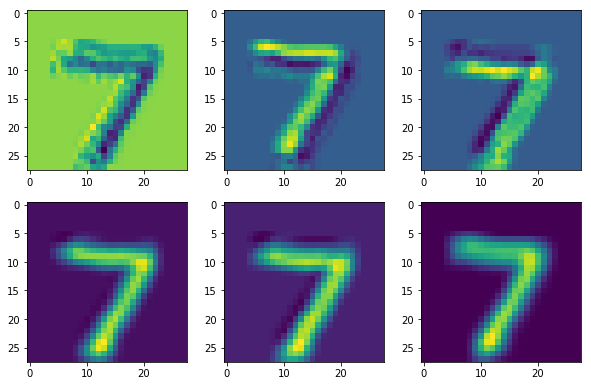

In [11]:

plt.figure(figsize=(10, 10))
row = 2
columns = 3
for i in range(6):
    output, min_val, max_val = quantize_arr(
        model.conv1.forward(input_img)[0][i].detach().numpy())
    plt.subplot(6 / columns + 1, columns, i + 1)
    plt.imshow(output)

## Conv1 Weights

In [13]:
for i in range(6):
  print("{}, Bias: {}\n".format(param[0][i].data, param[1][i]))
  print("Min: {}, Max: {}\n".format(np.min(param[0][i].data.numpy()), np.max(param[0][i].data.numpy())))

tensor([[[-0.0114,  0.0654, -0.1195,  0.1834, -0.1267],
         [-0.0137, -0.1503, -0.1956,  0.1240, -0.0959],
         [-0.0175,  0.0455, -0.1688, -0.0688,  0.1024],
         [-0.1575,  0.1796,  0.1005, -0.1383, -0.0074],
         [-0.1698, -0.1241, -0.0044,  0.1310, -0.0246]]]), Bias: -0.11180946230888367

Min: -0.1956416666507721, Max: 0.18343065679073334

tensor([[[-0.1325,  0.1517, -0.0401,  0.1834, -0.0111],
         [ 0.0429, -0.1438, -0.0643,  0.1237, -0.0803],
         [-0.0520, -0.0196, -0.1607, -0.0416,  0.0577],
         [-0.1035,  0.0624,  0.1438,  0.0649, -0.0487],
         [-0.0349, -0.0219,  0.2134,  0.2538,  0.2689]]]), Bias: 0.00138037686701864

Min: -0.1606946736574173, Max: 0.26888108253479004

tensor([[[ 0.1488,  0.2540,  0.0795, -0.0328,  0.2178],
         [ 0.2277, -0.0392,  0.2099,  0.1008,  0.0209],
         [ 0.0952, -0.1385,  0.0809, -0.1658, -0.0369],
         [-0.1753,  0.1621, -0.0050,  0.0560, -0.0695],
         [ 0.1056,  0.1371, -0.0760, -0.1800, -0.10

## Pool1 Feature Maps

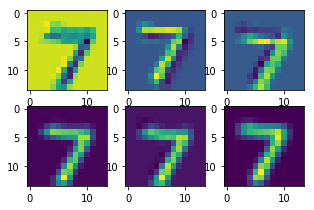

In [14]:
param = list(model.parameters())
plt.figure(figsize=(5, 5))
row = 2
columns = 3
for i in range(6):
    output, min_val, max_val = quantize_arr(
        model.pool1.forward(
            model.conv1.forward(input_img))[0][i].detach().numpy())
    plt.subplot(6 / columns + 1, columns, i + 1)
    plt.imshow(output)


## Conv2 Feature Maps

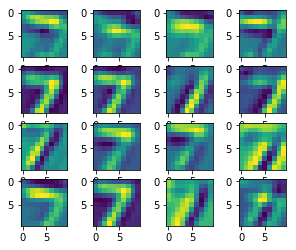

In [15]:
plt.figure(figsize=(5, 5))
row = 4
columns = 4
for i in range(16):
    output, min_val, max_val = quantize_arr(
        model.conv2.forward(
            model.pool1.forward(
                model.conv1.forward(input_img)))[0][i].detach().numpy())
    plt.subplot(16 / columns + 1, columns, i + 1)
    plt.imshow(output)


## Conv2 Weights

In [16]:
for i in range(16):
  print("{}, Bias: {}\n".format(param[2][i].data, param[3][i]))
  print("Min: {}, Max: {}\n".format(np.min(param[2][i].data.numpy()), np.max(param[2][i].data.numpy())))

tensor([[[-6.1135e-02,  6.8413e-02, -4.0683e-02, -1.1245e-02,  5.6356e-02],
         [ 7.2667e-02,  5.7125e-02,  6.6862e-02, -7.4814e-02, -1.4887e-02],
         [ 7.0826e-02,  1.1580e-02,  3.1594e-02, -5.8298e-02,  3.7172e-02],
         [ 4.2851e-02, -6.7081e-02, -6.7996e-02, -7.8177e-02, -1.7279e-02],
         [ 3.5327e-02, -3.8703e-02, -7.7611e-02, -6.9788e-02, -6.7684e-02]],

        [[-1.4790e-03,  3.6950e-02,  5.5986e-02,  2.0353e-02, -8.2054e-02],
         [-7.2476e-02,  9.2301e-03, -4.2883e-03, -1.9025e-02, -4.9680e-02],
         [ 3.1558e-02,  1.8741e-02, -3.3891e-02, -1.2026e-02,  3.9307e-02],
         [-4.4046e-02, -7.4719e-02, -1.9774e-02, -7.8834e-02, -3.3617e-02],
         [ 6.9993e-02,  5.7156e-02,  1.7886e-02, -4.2830e-02,  4.2741e-02]],

        [[-2.7385e-02,  2.8226e-02, -6.1625e-03,  2.1928e-02,  6.1837e-02],
         [-7.2974e-02, -7.8798e-02,  2.8730e-02,  1.6174e-02, -7.1875e-02],
         [ 2.3010e-02,  7.0536e-02,  3.6993e-02, -3.2266e-02,  4.6003e-02],
        

## Pool2 Feature Maps

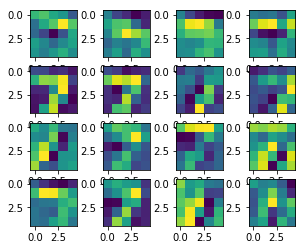

In [17]:
plt.figure(figsize=(5, 5))
row = 4
columns = 4
for i in range(16):
    output, min_val, max_val = quantize_arr(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img))))[0][i].detach().numpy())
    plt.subplot(16 / columns + 1, columns, i + 1)
    plt.imshow(output)


## Conv3 Outputs

In [18]:
param = list(model.parameters())

for i in range(120):
    output = model.conv3.forward(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img)))))[0][i].detach().numpy()
    print(output)


[[-3.5356452]]
[[18.136824]]
[[8.515239]]
[[-4.312608]]
[[-2.503005]]
[[-1.9758595]]
[[6.9462113]]
[[-2.0296934]]
[[1.6552446]]
[[11.296704]]
[[6.9381113]]
[[1.0449294]]
[[4.660225]]
[[-0.08531591]]
[[-1.4428309]]
[[-9.941525]]
[[-0.90498126]]
[[-9.295906]]
[[-1.4024513]]
[[-1.3098317]]
[[11.1732025]]
[[-4.3714566]]
[[3.177301]]
[[8.430946]]
[[-5.536315]]
[[0.12552004]]
[[-7.9152684]]
[[-3.7696629]]
[[-11.9204]]
[[10.072893]]
[[-8.717486]]
[[-1.5210173]]
[[4.23871]]
[[11.8119]]
[[-2.129735]]
[[-0.67864794]]
[[-3.2699645]]
[[9.7878475]]
[[-2.53795]]
[[-2.930499]]
[[-11.993685]]
[[4.748204]]
[[16.901325]]
[[1.4684601]]
[[11.984684]]
[[2.339158]]
[[-1.8012514]]
[[-3.1108181]]
[[-12.019759]]
[[1.6367074]]
[[-4.7395654]]
[[-2.0607116]]
[[-0.65374553]]
[[-6.658676]]
[[-1.9603895]]
[[-0.3406203]]
[[9.338638]]
[[-0.7987924]]
[[-0.4542301]]
[[-2.4815383]]
[[2.617889]]
[[-8.811692]]
[[-3.5715122]]
[[0.22363277]]
[[1.0669318]]
[[-5.1687055]]
[[4.744575]]
[[-1.832405]]
[[3.580447]]
[[-2.1754308]]


## Conv3 Weights

In [19]:
for i in range(120):
  print("{}, Bias: {}\n".format(param[4][i].data, param[5][i]))
  print("Min: {}, Max: {}\n".format(np.min(param[4][i].data.numpy()), np.max(param[4][i].data.numpy())))

tensor([[[ 4.1817e-04,  4.5676e-02,  4.9264e-02, -7.0762e-03,  7.6563e-03],
         [-2.4537e-02, -8.4874e-03,  2.3212e-02,  6.2014e-03,  2.0393e-02],
         [ 1.9660e-02, -6.0965e-03, -3.9718e-02, -3.5335e-02, -2.1464e-02],
         [-2.8391e-03,  2.0533e-02, -4.1028e-02, -4.2544e-03,  4.8430e-02],
         [ 2.8321e-03, -4.1575e-02, -1.5893e-02, -1.3001e-02, -2.4326e-02]],

        [[ 8.7470e-03,  2.7322e-03,  4.8976e-02, -7.4298e-04,  3.8752e-02],
         [ 5.0570e-03, -3.0657e-02, -3.2720e-02, -4.7258e-03, -1.2057e-02],
         [-1.4870e-02,  5.2398e-02, -2.0805e-02,  3.7318e-03, -8.5508e-03],
         [-4.1472e-02, -5.8620e-02,  6.0972e-02,  2.5902e-02,  3.1251e-02],
         [ 3.1220e-02, -2.7063e-02,  1.9109e-02,  4.7929e-02,  5.9064e-02]],

        [[ 4.1534e-02,  4.4736e-02, -1.2430e-02, -3.2795e-02, -3.5228e-02],
         [-2.3602e-03,  6.0026e-03, -4.8139e-02, -1.0932e-02, -3.4237e-03],
         [-2.6270e-02, -3.7571e-02,  2.3018e-02,  4.2253e-02, -1.8047e-02],
        

## FC1 Outputs

In [0]:
output = model.fc1.forward(torch.flatten(
    model.conv3.forward(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img))))), start_dim=1))[0].detach().numpy()
    
print(output)

[ 17.052557    -7.235403    -3.6454833    2.3655057   18.160534
   5.107145     8.610383    -0.6661482    9.172992    -5.848117
   2.7296278   20.40245     -9.28049      9.339558    13.761778
   3.8329084   -4.3581643    5.477696     0.15404093   9.3164625
  13.526836    14.346575    -3.9229755   11.003507     9.0602865
 -13.932806     6.7081037    3.8567045   -4.1894355   -5.949504
  -2.5642912    0.39991692   6.6550145  -13.364462    -3.2279844
   8.049945    -7.722157     9.204617   -20.90334     -6.579002
  -1.9639748   -3.9345443   11.661445     1.3674448   -3.0023632
  -5.89906      6.9045625    4.4984126  -17.89018     11.466324
  17.616102     4.260994     7.4242053    1.0693616   -5.722455
  -2.220241    -1.873821    -1.7719783    2.884684    -1.0229753
 -15.74398      1.6553037   21.571533    -4.4592004   25.772303
   4.587804    12.146106    12.4637165    2.4061997   16.633615
   8.829457     4.1301003   11.76523      6.044397    16.766531
   3.7532063   -0.31100765  -5.9940

## FC1 Weights

In [0]:
for i in range(84):
  print("{}, Bias: {}\n".format(param[6][i].data, param[7][i]))
  print("Min: {}, Max: {}\n".format(np.min(param[6][i].data.numpy()), np.max(param[6][i].data.numpy())))

tensor([-0.0462,  0.0337, -0.0027, -0.0442,  0.0160,  0.0376, -0.0812, -0.0858,
         0.0147, -0.0721,  0.0610,  0.0065, -0.0402,  0.0733, -0.0142, -0.0468,
         0.0746, -0.0634,  0.0004,  0.0694, -0.0013, -0.0774,  0.1980,  0.0619,
        -0.0387,  0.0180, -0.0716, -0.0145,  0.0098, -0.0368,  0.0990,  0.0093,
         0.0217, -0.1558, -0.0416,  0.0002,  0.1141, -0.0091, -0.0387,  0.0397,
        -0.0284, -0.0650,  0.0368, -0.0087, -0.0159,  0.0796, -0.0707, -0.1152,
         0.0546,  0.1128, -0.0649,  0.0574, -0.0287, -0.0402,  0.0513,  0.0604,
        -0.0599, -0.0455, -0.0705, -0.1111,  0.0042,  0.0238, -0.0683, -0.0485,
         0.0098,  0.0948,  0.0643, -0.1031,  0.0070,  0.0693,  0.0772,  0.0251,
         0.0379,  0.0680,  0.0163, -0.0510, -0.0161,  0.0409,  0.0096,  0.0548,
        -0.0417, -0.0967, -0.1298, -0.0688,  0.0148, -0.0370, -0.0037, -0.0112,
         0.0774, -0.0550, -0.0820,  0.0692,  0.0793, -0.0971, -0.0638,  0.0888,
         0.0723, -0.0357, -0.0622,  0.06

## FC2 Outputs

In [0]:
output = model.fc2.forward(model.fc1.forward(torch.flatten(
    model.conv3.forward(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img))))), start_dim=1)))[0].detach().numpy()
    
print(output)

[ 23.552961 -49.215607 -25.085241  13.662104  -8.299734 -10.060858
 -60.111736  61.66301   27.06371   50.762844]


## FC2 Weights

In [0]:
for i in range(10):
  print("{}, Bias: {}\n".format(param[8][i].data, param[9][i]))
  print("Min: {}, Max: {}\n".format(np.min(param[8][i].data.numpy()), np.max(param[8][i].data.numpy())))

tensor([ 0.2247,  0.0666, -0.0173,  0.0577,  0.2161, -0.0485, -0.0409,  0.0837,
         0.1539,  0.1229, -0.1730,  0.1596, -0.1262, -0.1334, -0.0585,  0.3362,
         0.0138,  0.0371, -0.0085, -0.0119, -0.1588,  0.1204,  0.0696,  0.0406,
        -0.2924, -0.1964,  0.1821,  0.0314,  0.0067, -0.0701, -0.0748, -0.0816,
         0.0532,  0.0252, -0.3614,  0.0334,  0.1708,  0.4232,  0.0031, -0.2386,
         0.0274, -0.0044,  0.1305, -0.0548,  0.0448, -0.0920,  0.0976,  0.2564,
        -0.0944, -0.1692,  0.1769, -0.1532,  0.0522,  0.0225, -0.1104,  0.2434,
        -0.1893,  0.1657,  0.0418,  0.0497, -0.2259, -0.3196, -0.2066, -0.2014,
        -0.1013,  0.0393,  0.1891, -0.0401,  0.0840,  0.1771,  0.0790, -0.2266,
        -0.0446,  0.0565, -0.1395, -0.1965,  0.1558,  0.0129,  0.0649, -0.1003,
         0.0430, -0.1636,  0.0835, -0.0129]), Bias: -0.0030939574353396893

tensor([-0.2229,  0.1105, -0.0011,  0.0225, -0.1771,  0.1404,  0.2437,  0.0211,
        -0.3798, -0.0742,  0.2421, -0.1551, 